# Exploratory analysis

## Looking at our data

In [3]:
import torch
from node2vec import Node2Vec
from torch_geometric.data import Data
from utils.gsn_argparse import str2bool, str2actication
import torch_geometric.utils as gutils
from torch_geometric.nn import GAE
import trainer
import utils.gsn_argparse as gap
import numpy as np
import pandas as pd
from sklearn import preprocessing
import networkx as nx
import matplotlib.pyplot as plt

## Label encoding

In [76]:
name = ['entity', 'id']
entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=name, engine='python')
entity = entity_id['entity'].values.tolist()
le_entity = preprocessing.LabelEncoder()
le_entity.fit(entity)

name = ['relation', 'id']
relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=name, engine='python')
relation = relation_id['relation'].values.tolist()
le_relation = preprocessing.LabelEncoder()
le_relation.fit(relation)

LabelEncoder()

In [100]:
name = ['subject', 'object', 'relation']
data = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=name, engine='python')

subjects = data['subject'].values.tolist()[:100]
objects = data['object'].values.tolist()[:100]
relations = data['relation'].values.tolist()[:100]

# string list to int array using LabelEncoder
subjects = np.array(le_entity.transform(subjects))
objects = np.array(le_entity.transform(objects))
relations = np.array(le_relation.transform(relations))

# encode subsample
le_entity2 = preprocessing.LabelEncoder().fit(np.append(subjects,objects))
le_relation2 = preprocessing.LabelEncoder().fit(relations)

subjects = np.array(le_entity2.transform(subjects))
objects = np.array(le_entity2.transform(objects))
relations = np.array(le_relation2.transform(relations))

train_set_raw = np.concatenate([subjects.reshape(-1, 1), relations.reshape(-1, 1), objects.reshape(-1, 1)], axis=1)
n_pos_samples = len(relations)

# entity_pair = [[subject, object]] y = [[relation]] edge_index = [[subject],[object]]
entity_pairs = torch.tensor(train_set_raw[:, 0:3:2], dtype=torch.float)

In [101]:
print(f"Subjects: {subjects}, \nObjects: {objects}, \nRelations: {relations}")

Subjects: [137 125 159 136   1  12  70  87  31  27  71 133  93 187 173 121  30  49
  53 143 156  48 162   8 117 181  42 126  54 106  51  11  28  39 182 141
  77  26  10  17 110 129  56  63 142 180   3  65 134 170  18 172 171  62
  59 128 169  90  40 180   9  89 174 139  80  16  75  82 188 108 118 183
  72  64  44 158 185  35 189 167  33 153  61  84  73  78  23 164 154  68
  92 102 116 166 161 177 151  22  41  14], 
Objects: [ 55  50  91 149 155   6 190 123 107   5 105 101  99   0  47  52 114 140
  57  74  79 179 109  47 103 107 111  94  37  96  34  60  29  38  19 176
 100  46 152 113 165 150 147 144 175 168  15 143  20 143 145 138 184  81
  32 160 115 104 132 178 143 124  95  43  25 157 163  58  88  45  86  13
  67 135 122  83 119  85 145 131 143  97 186  98  24 127   2 120 147  21
  76 148 130  69 112 146  66  36   7   4], 
Relations: [25 42 13  0 34 64  2 57 63 32  3 28 51 64 27 69 16 54  9 20 44 30 58 27
 46 63 14 30 41 31 67  7 29 17 63 70 45 24 10  1 46  6 23 48 10 11  5 21
  8 21

In [102]:
oh_entity = preprocessing.OneHotEncoder(handle_unknown='ignore')
oh_entity.fit(entity_pairs)
entity_pairs2 = oh_entity.transform(entity_pairs)
y_le = preprocessing.LabelEncoder().fit_transform(train_set_raw[:, 1])
y = torch.tensor(y, dtype=torch.float)
edge_index = torch.tensor([train_set_raw[:,0], train_set_raw[:,2]], dtype=torch.long)
unique_entities = torch.tensor(np.unique(edge_index.reshape(entity_pairs.shape[0]*2, 1)), dtype=torch.float)

dataset = Data(x=unique_entities,y=y, edge_index=edge_index)

c:\users\oddgu\programmering\multirelational-graphstar\env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [103]:
label_dict ={}
for n1, n2, ys in zip(subjects, objects, y):
    label_dict[int(n1), int(n2)] = int(ys)

In [108]:
def visualize(h, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=True,
                          cmap="Set2")
        nx.draw_networkx_edge_labels(h, pos=nx.spring_layout(h, seed=42), edge_labels=label_dict, cmap="Set2")
    plt.show()

In [113]:
from torch_geometric.utils import to_networkx
G = to_networkx(dataset)
print(G.number_of_nodes())
print(dataset.num_nodes)

191
191


<IPython.core.display.Javascript object>


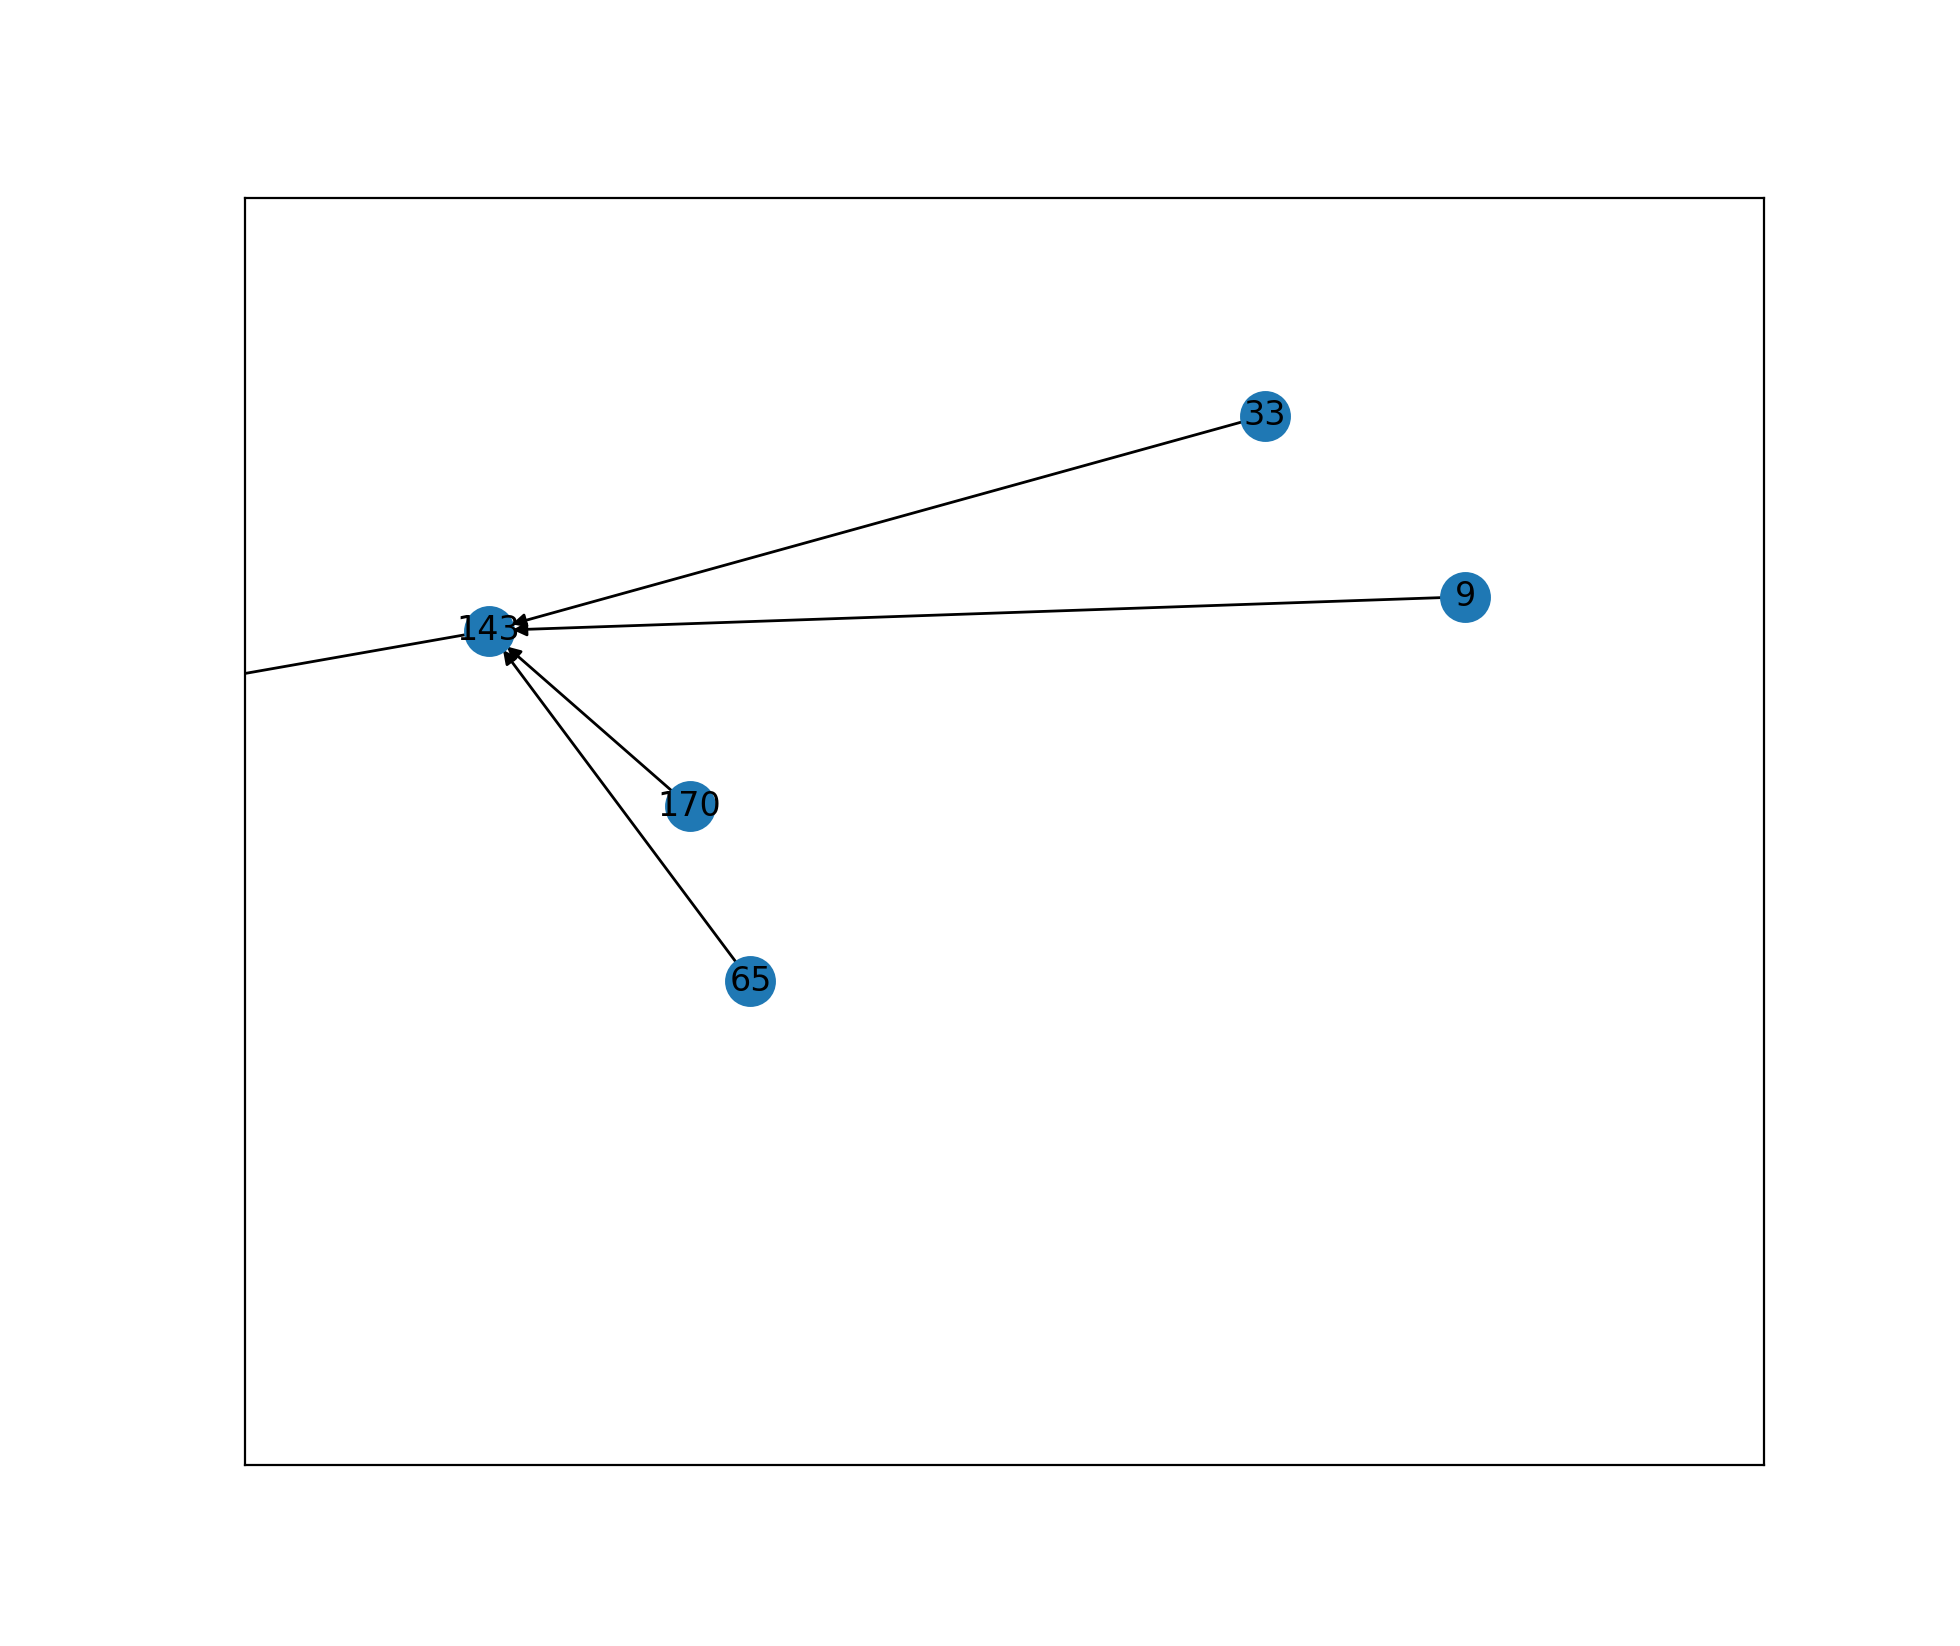

In [110]:
%matplotlib notebook
visualize(G)

In [ ]:
print(le_entity.inverse_transform([2258, 6305]))
le_relation.inverse_transform([639])

In [46]:
y = torch.tensor([3,0,0,0,1,1,2,2,3,1], dtype=torch.float)
edge_index = torch.tensor([[0,0,0,9,0,2,5,2,3,2,7,0,3,2,7,6,7,4], [1,2,3,4,2,3,5,6,7,8,9,9,5,4,3,2,5,3]], dtype=torch.long)
x = torch.tensor([0,1,2,3,4,5,6,7,8,9], dtype=torch.float)

dataset = Data(x=x, y=y, edge_index=edge_index)

In [ ]:
model = torch.load("output/FB15K.pkl")

In [ ]:
model.link_prediction

In [ ]:
model.training

In [ ]:
edge_index = torch.tensor([[0],[10505]], dtype=torch.long)
x = torch.tensor([[10039, 4677],[9561,4397], [11924,  6872],[12966, 12859]], dtype=torch.float)
batch = torch.zeros((1, len(x)), dtype=torch.int64).view(-1)
star_seed = None
edge_type = torch.zeros(((edge_index.size(-1)),)).long()

In [ ]:
 logits_node, logits_star, logits_lp = model(x, edge_index, batch, star=star_seed, edge_type=edge_type)

In [ ]:
x = torch.tensor([[10039, 4677],[9561,4397], [11924,  6872],[12966, 12859]], dtype=torch.float)


In [ ]:
y = model.fl(x)

In [ ]:
y[0].argmax(), y[1].argmax(), y[2].argmax(), y[3].argmax(), 

In [ ]:
len(y[0])